To group genes based on the temporal shape of their expression or accessibility changes, identifying shared dynamic patterns (e.g., early up, transient drop). This reveals coordinated response behaviors not apparent from magnitude alone, supporting second-generation ensemble analysis.

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# this cell runs this pipeline and saves the data for all chr.
# for individual analysis, see each cells below
def interpret_pattern(arr):
    arr = np.array(arr)
    if len(arr) == 3:
        d1, d2 = arr[1] - arr[0], arr[2] - arr[1]
        trend = np.polyfit([12, 18, 24], arr, 1)[0]
        if d1 > 0.2 and d2 > 0.2:
            return "gradual up"
        elif d1 < -0.2 and d2 < -0.2:
            return "gradual down"
        elif d1 > 0.2 and d2 < -0.2:
            return "brief spike"
        elif d1 < -0.2 and d2 > 0.2:
            return "brief dip"
        elif abs(trend) < 0.15:
            return "flat"
        elif d1 > 0 and d2 > 0.05:
            return "late up"
        elif d1 < 0 and d2 < -0.05:
            return "late down"
        else:
            return "complex/other"
    else:
        return "unknown"

def run_temporal_shape(df, cols, feat_label):
    # Z-score normalization
    data = df[cols].values
    z = StandardScaler().fit_transform(data)
    emb = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42).fit_transform(z)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
    clusters = clusterer.fit_predict(emb)

    df_ = df.copy()
    df_[f"{feat_label}_cluster"] = clusters

    # Compute cluster patterns
    cluster_avg = {}
    for c in sorted(set(clusters)):
        if c == -1: continue
        avg = df_[df_[f"{feat_label}_cluster"] == c][cols].mean().values
        cluster_avg[c] = avg

    # Interpret each cluster
    cluster_labels = {c: interpret_pattern(v) for c, v in cluster_avg.items()}

    # Assign pattern label
    pattern_label_col = f"{feat_label}_pattern"
    def get_label(row):
        c = row[f"{feat_label}_cluster"]
        return cluster_labels.get(c, "noise")
    df_[pattern_label_col] = df_.apply(get_label, axis=1)

    return df_[['gene_name'] + cols + [pattern_label_col]]

def extract_temporal_value_trend(file_path):
    for chr_folder_name in os.listdir(file_path):
        chr_path = os.path.join(file_path, chr_folder_name)
        if not os.path.isdir(chr_path) or not chr_folder_name.startswith('chr'):
            continue

        df = pd.read_csv(f"{chr_path}/{chr_folder_name}_expr_acc_features.csv")
        
        expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
        acc_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
        all_cols = expr_cols + acc_cols
        
        df_filtered = df.dropna(subset=all_cols)
        print(f"{chr_folder_name}: Total genes: {len(df)}; Genes used: {len(df_filtered)}")

        # ---- Run for expression ----
        res_expr = run_temporal_shape(df_filtered, expr_cols, 'expression')
        
        # ---- Run for accessibility ----
        res_acc = run_temporal_shape(df_filtered, acc_cols, 'accessibility')

        # ---- Merge and construct combined pattern directly ----
        results = res_expr[['gene_name', 'expression_pattern']].merge(
            res_acc[['gene_name', 'accessibility_pattern']], on='gene_name'
        )
        results["combined_pattern"] = results["expression_pattern"] + " & " + results["accessibility_pattern"]

        results.to_csv(f"{chr_path}/{chr_folder_name}_temporal_value_patterns.csv", index=False)
        print(f"{chr_folder_name} data saved")

file_path = 'data/green_monkey/all_structure_files/'
extract_temporal_value_trend(file_path)


chr23: Total genes: 597; Genes used: 397


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr23 data saved
chr12: Total genes: 895; Genes used: 589


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr12 data saved
chr15: Total genes: 533; Genes used: 309


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr15 data saved
chr14: Total genes: 830; Genes used: 480


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr14 data saved
chr13: Total genes: 499; Genes used: 251


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Total genes: 1323; Genes used: 802


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


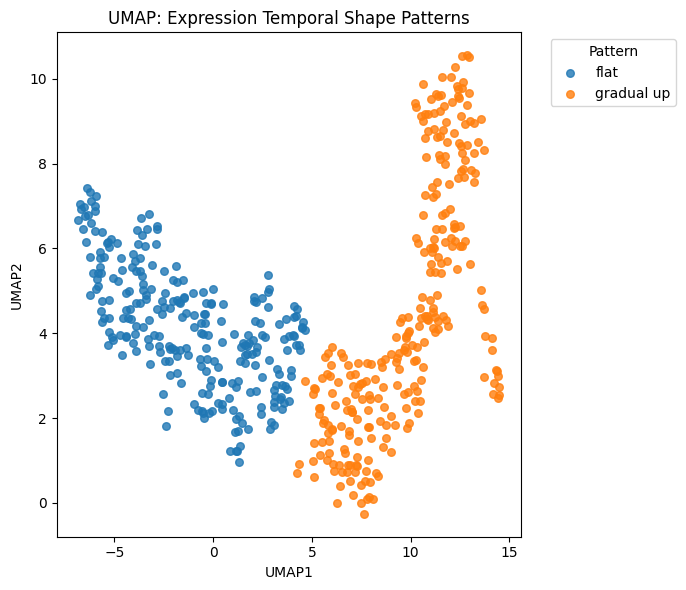

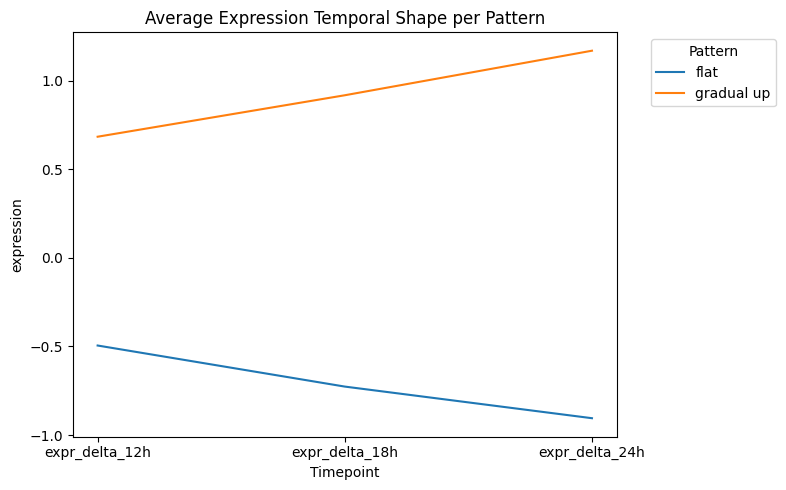

/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


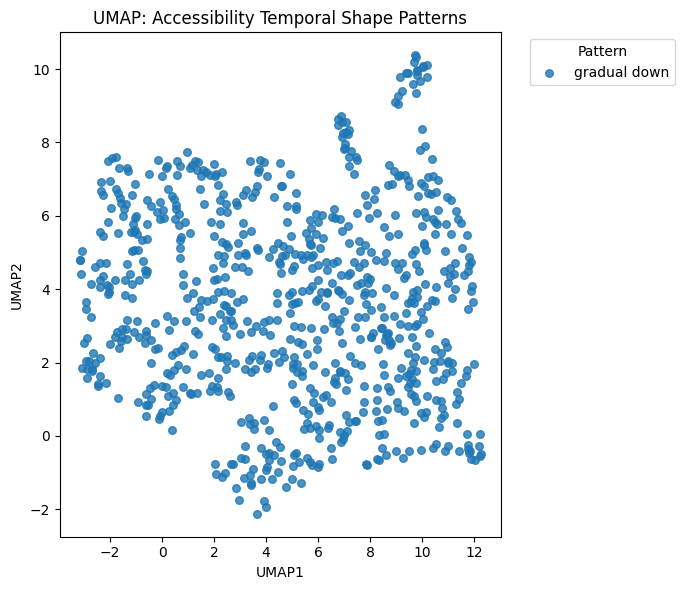

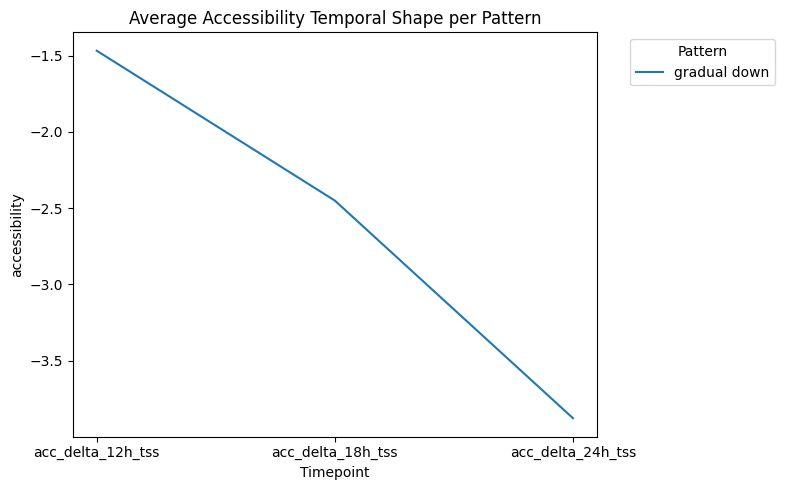

  gene_name expression_pattern accessibility_pattern  \
0     BET1L               flat          gradual down   
1     RIC8A               flat          gradual down   
2     SIRT3               flat          gradual down   
3    PSMD13               flat          gradual down   
4     NLRP6         gradual up          gradual down   

            combined_pattern  
0        flat & gradual down  
1        flat & gradual down  
2        flat & gradual down  
3        flat & gradual down  
4  gradual up & gradual down  


In [16]:
# ---- Load data ----
df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_features.csv")

expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
acc_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
all_cols = expr_cols + acc_cols

df_filtered = df.dropna(subset=all_cols)
print(f"Total genes: {len(df)}; Genes used: {len(df_filtered)}")

def interpret_pattern(arr):
    arr = np.array(arr)
    if len(arr) == 3:
        d1, d2 = arr[1] - arr[0], arr[2] - arr[1]
        trend = np.polyfit([12, 18, 24], arr, 1)[0]
        if d1 > 0.2 and d2 > 0.2:
            return "gradual up"
        elif d1 < -0.2 and d2 < -0.2:
            return "gradual down"
        elif d1 > 0.2 and d2 < -0.2:
            return "brief spike"
        elif d1 < -0.2 and d2 > 0.2:
            return "brief dip"
        elif abs(trend) < 0.15:
            return "flat"
        elif d1 > 0 and d2 > 0.05:
            return "late up"
        elif d1 < 0 and d2 < -0.05:
            return "late down"
        else:
            return "complex/other"
    else:
        return "unknown"

def run_temporal_shape(df, cols, feat_label):
    # Z-score normalization
    data = df[cols].values
    z = StandardScaler().fit_transform(data)
    emb = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42).fit_transform(z)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
    clusters = clusterer.fit_predict(emb)

    df_ = df.copy()
    df_[f"{feat_label}_cluster"] = clusters

    # Compute cluster patterns
    cluster_avg = {}
    for c in sorted(set(clusters)):
        if c == -1: continue
        avg = df_[df_[f"{feat_label}_cluster"] == c][cols].mean().values
        cluster_avg[c] = avg

    # Interpret each cluster
    cluster_labels = {c: interpret_pattern(v) for c, v in cluster_avg.items()}

    # Assign pattern label
    pattern_label_col = f"{feat_label}_pattern"
    def get_label(row):
        c = row[f"{feat_label}_cluster"]
        return cluster_labels.get(c, "noise")
    df_[pattern_label_col] = df_.apply(get_label, axis=1)

    # ---- UMAP scatter plot with pattern label colors ----
    palette = sns.color_palette("tab10", len(set(cluster_labels.values())))
    pat2color = {p: palette[i % len(palette)] for i, p in enumerate(sorted(set(cluster_labels.values())))}
    plt.figure(figsize=(7, 6))
    for pat in sorted(set(cluster_labels.values())):
        idx = df_[pattern_label_col] == pat
        plt.scatter(emb[idx, 0], emb[idx, 1], label=pat, color=pat2color[pat], alpha=0.8, s=30)
    plt.title(f"UMAP: {feat_label.capitalize()} Temporal Shape Patterns")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # ---- Average time series per pattern label ----
    plt.figure(figsize=(8, 5))
    for pat in sorted(set(cluster_labels.values())):
        idx = df_[pattern_label_col] == pat
        avg = df_.loc[idx, cols].mean()
        plt.plot(cols, avg, label=pat)
    plt.title(f"Average {feat_label.capitalize()} Temporal Shape per Pattern")
    plt.xlabel("Timepoint")
    plt.ylabel(feat_label)
    plt.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return df_[['gene_name'] + cols + [pattern_label_col]]

# ---- Run for expression ----
res_expr = run_temporal_shape(df_filtered, expr_cols, 'expression')

# ---- Run for accessibility ----
res_acc = run_temporal_shape(df_filtered, acc_cols, 'accessibility')

# ---- Merge and directly assign combined pattern ----
results = res_expr[['gene_name', 'expression_pattern']].merge(
    res_acc[['gene_name', 'accessibility_pattern']], on='gene_name'
)
results["combined_pattern"] = results["expression_pattern"] + " & " + results["accessibility_pattern"]

# ---- Save ----
# results.to_csv("data/green_monkey/all_structure_files/chr1/chr1_temporal_shape_patterns_annotated.csv", index=False)
print(results.head())
